## Problem Description
Insurance companies take risks over customers. Risk management is a very important aspect of the insurance industry. Insurers consider every quantifiable factor to develop profiles of high and low insurance risks. Insurers collect vast amounts of information about policyholders and analyze the data.

As a Data scientist in an insurance company, you need to analyze the available data and predict whether to sanction the insurance or not.

## Dataset Description
A zipped file containing train, test and sample submission files are given. The training dataset consists of data corresponding to 52310 customers and the test dataset consists of 22421 customers. Following are the features of the dataset

- Target: Claim Status (Claim)
- Name of agency (Agency)
- Type of travel insurance agencies (Agency.Type)
- Distribution channel of travel insurance agencies (Distribution.Channel)
- Name of the travel insurance products (Product.Name)
- Duration of travel (Duration)
- Destination of travel (Destination)
- Amount of sales of travel insurance policies (Net.Sales)
- The commission received for travel insurance agency (Commission)
- Age of insured (Age)
- The identification record of every observation (ID)

# Evaluation Metric
The evaluation metric for this task will be **precision_score**.

**=========================================Data Analaysis Begins=========================================**

### Importing Necessary Pacakages

In [45]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score,recall_score,f1_score,cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
import smote_variants as sv
from sklearn.model_selection import cross_validate

In [5]:
# pip install smote_variants
# pip3 install --upgrade tensorflow-gpu --user

SyntaxError: invalid syntax (<ipython-input-5-9839c392dc1c>, line 1)

Defining path for data files

In [2]:
train_path='./train.csv'
test_path='./test.csv'

Loading data

In [3]:
df_train=pd.read_csv(train_path)
df_test=pd.read_csv(test_path)

Getting intution about data with head and describe

In [4]:
df_test.head()

ID Agency    Agency Type Distribution Channel              Product Name  \
0  17631    EPX  Travel Agency               Online         Cancellation Plan   
1  15064    EPX  Travel Agency               Online  1 way Comprehensive Plan   
2  14139    C2B       Airlines               Online               Bronze Plan   
3  19754    EPX  Travel Agency               Online  2 way Comprehensive Plan   
4  16439    C2B       Airlines               Online               Silver Plan   

   Duration                Destination  Net Sales  Commision (in value)  Age  
0       192                  HONG KONG       18.0                  0.00   36  
1         2                  SINGAPORE       20.0                  0.00   36  
2        13                  SINGAPORE       13.5                  3.38   24  
3       133  TAIWAN, PROVINCE OF CHINA       41.0                  0.00   36  
4         2                  SINGAPORE       30.0                  7.50   32

In [5]:
df_test.describe()

ID      Duration     Net Sales  Commision (in value)  \
count  22421.000000  22421.000000  22421.000000          22421.000000   
mean   15499.196646     59.100665     49.446070             12.316924   
std     2606.751171    114.819397     61.794609             22.957306   
min    11000.000000     -1.000000   -297.000000              0.000000   
25%    13236.000000     10.000000     19.800000              0.000000   
50%    15515.000000     24.000000     29.518868              0.000000   
75%    17762.000000     58.000000     56.000000             13.630000   
max    20000.000000   4857.000000    810.000000            283.500000   

                Age  
count  22421.000000  
mean      39.784889  
std       13.910773  
min        1.000000  
25%       34.000000  
50%       36.000000  
75%       43.000000  
max      118.000000

In [6]:
df_train.describe()

ID      Duration     Net Sales  Commision (in value)  \
count  52310.000000  52310.000000  52310.000000          52310.000000   
mean    6005.745804     58.256108     48.554673             12.219963   
std     2306.450475    109.138708     60.198589             22.847645   
min     2000.000000     -2.000000   -389.000000              0.000000   
25%     4015.000000     10.000000     19.800000              0.000000   
50%     6002.000000     24.000000     29.500000              0.000000   
75%     8004.000000     57.000000     55.000000             13.380000   
max    10000.000000   4881.000000    682.000000            262.760000   

                Age         Claim  
count  52310.000000  52310.000000  
mean      39.555725      0.166699  
std       13.762473      0.372710  
min        0.000000      0.000000  
25%       33.000000      0.000000  
50%       36.000000      0.000000  
75%       43.000000      0.000000  
max      118.000000      1.000000

In [7]:
# checking the class imbalance in train data
df_train['Claim'].value_counts(normalize = True)*100

0    83.330147
1    16.669853
Name: Claim, dtype: float64

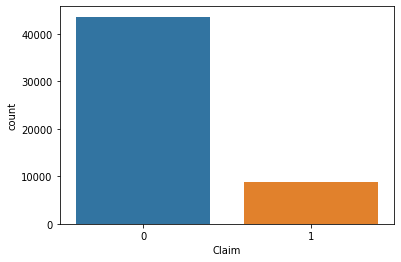

In [8]:
sns.countplot(df_train['Claim'])

# Seems there is some class imbalance


# Question to Ask:

- How Duration can be negative, values are in Train and Test Both.
- Amount of Net Sales is in Negative in both Train and Test.


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52310 entries, 0 to 52309
Data columns (total 11 columns):
ID                      52310 non-null int64
Agency                  52310 non-null object
Agency Type             52310 non-null object
Distribution Channel    52310 non-null object
Product Name            52310 non-null object
Duration                52310 non-null int64
Destination             52310 non-null object
Net Sales               52310 non-null float64
Commision (in value)    52310 non-null float64
Age                     52310 non-null int64
Claim                   52310 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 4.4+ MB


Above summary shows no column has **"Null"** Values. We can also see there are 6 columns having numerical data and other are categorical data.

## Segregating Numerical and Object data

In [10]:
numerical_cols=df_train.select_dtypes(include=['int64','float64'])
categorical_cols=df_train.select_dtypes(include='object')
numerical_cols_test=df_test.select_dtypes(include=['int64','float64'])
categorical_cols_test=df_test.select_dtypes(include='object')

In [12]:
categorical_cols.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Destination'],
      dtype='object')

### With above information and basic analysis we can conclude following:
- **ID:** Numerical value for reference, No significane in stastical analysis.
- **Duration:** 
    - has values in negative. Which is not possible, Time can't be in negative. This will need further analysis as how many occurances of such data.
    - has High Variance
    - Standard Deviation of 109 against mean 58 suggest data is largely dispersed
- **Net Sales:**
    - Has Values in negative. Need more investigation.
    - Data is releativley clsoer to mean
    - variance is high
- **Commision (in value):**
    - closer to mean
    - no negative value
    - 50% data has value as 0
- **Age:**
    - Age having Min as 0 suggests unit is in years.
    - Standard Deviation is low suggest data is closer to mean.
- **Claim:**
    - Boolean value and is target Variable
    

In [11]:
numerical_cols = numerical_cols.copy()
#Droping ID from Numerical Columns
numerical_cols.drop(columns=["ID","Claim"],axis=1,inplace=True)

## Opeartion on Numerical Data
### Checking skewness 

In [12]:
skew_check={}
for i in numerical_cols.columns:
    skew_check[i]=numerical_cols[i].skew()

In [13]:
skew_check

{'Duration': 15.3525235978114,
 'Net Sales': 2.811837338046441,
 'Commision (in value)': 3.5356943446774736,
 'Age': 2.9478911827909426}

Above value shows All numerical data is **postive skewed**.Applying Transformation techniques for data to follow **Guassian distribution**

In [14]:
df_train['Net Sales'].describe()

count    52310.000000
mean        48.554673
std         60.198589
min       -389.000000
25%         19.800000
50%         29.500000
75%         55.000000
max        682.000000
Name: Net Sales, dtype: float64

## Opeartion on Categorical Data

In [15]:
categorical_cols.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Destination'],
      dtype='object')

In [17]:
for i in categorical_cols:
    print("Column {} has {} unique values".format(i,len(categorical_cols[i].value_counts())))

Column Agency has 16 unique values
Column Agency Type has 2 unique values
Column Distribution Channel has 2 unique values
Column Product Name has 25 unique values
Column Destination has 97 unique values


Analysing above data it suggests columns **"Agency Type"** & **"Agency"** are of Boolean in nature.However rest 3 columns are of Non Boolean in nature hence opting for **LabelEncoding**.

In [18]:
le=preprocessing.LabelEncoder() #Intialising LabelEncoder Model
df_train_enc=pd.DataFrame() #Creating Empty Dataframe to store encoded Values

for i in (categorical_cols.columns): #Looping through to encode each columns
    df_train_enc[i] = le.fit_transform(df_train[i])   

In [19]:
#This is not the correct way
df_test_enc=pd.DataFrame() #Creating Empty Dataframe to store encoded Values
for i in (categorical_cols_test.columns):
    df_test_enc[i] = le.fit_transform(df_test[i])

In [20]:
df_test_enc.Agency.unique()

array([ 7,  2,  6, 11, 14,  9, 12,  4,  8, 13, 10,  0,  1, 15,  5,  3],
      dtype=int64)

In [21]:
df_train_enc.Agency.unique()

array([ 7,  6,  9,  2, 12, 14,  5,  8, 11, 13,  1,  4, 10,  0,  3, 15],
      dtype=int64)

In [22]:
df_train_enc.head() #Checking for encoded values

Agency  Agency Type  Distribution Channel  Product Name  Destination
0       7            1                     1            10           68
1       7            1                     1            10           53
2       6            1                     1            16           84
3       7            1                     1             1           33
4       7            1                     1             1           53

Merging dataframes (Encoded +Tranformed)

In [23]:
df_train_Modified=pd.concat([numerical_cols,df_train_enc],axis=1) #Adding both dataframes
df_test_Modified=pd.concat([numerical_cols_test,df_test_enc],axis=1) #Adding both dataframes

In [24]:
df_train_Modified.head()
#df_train_clean_power['Net Sales'].min()

Duration  Net Sales  Commision (in value)  Age  Agency  Agency Type  \
0        61       12.0                  0.00   41       7            1   
1         4       17.0                  0.00   35       7            1   
2        26       19.8                 11.88   47       6            1   
3        15       27.0                  0.00   48       7            1   
4        15       37.0                  0.00   36       7            1   

   Distribution Channel  Product Name  Destination  
0                     1            10           68  
1                     1            10           53  
2                     1            16           84  
3                     1             1           33  
4                     1             1           53

### Applying Feature Selection Technique

In [25]:
clean_skew=df_train_Modified.skew()

clean_skew

Duration                15.352524
Net Sales                2.811837
Commision (in value)     3.535694
Age                      2.947891
Agency                  -0.097111
Agency Type             -0.718350
Distribution Channel    -7.465242
Product Name             0.332685
Destination             -0.590582
dtype: float64

## Model Building

### Splliting data in Feature and Target variable

In [26]:
#Data with Log Transformed
X=df_train_Modified #Features
y=df_train['Claim'] #Target

In [27]:
# Train Test Split Log Transformed Data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=3)

In [28]:
#Checking for shape of Training data
print("Shape of X Train:",X_train.shape," & Y Train is ",y_train.shape)

Shape of X Train: (41848, 9)  & Y Train is  (41848,)


### Model Execution

#### Building Random Forest model after finalizing 

In [30]:
#Base Model
rf=RandomForestClassifier(n_estimators=1000,min_samples_leaf=1,max_features='log2',max_depth=40,criterion='gini',class_weight='balanced_subsample')
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
rf_score=accuracy_score(y_test,y_pred)
rf_precision_score=precision_score(y_test,y_pred)
print('rf_score',rf_score)
print('rf_precision_score',rf_precision_score)
print("cohen's kappa = " , cohen_kappa_score(y_test,y_pred))

rf_score 0.9449436054291722
rf_precision_score 0.8536737235367372
cohen's kappa =  0.7937250025433036


In [31]:
pd.crosstab(y_test,y_pred, rownames=['Predicted'], colnames=['Actual'])# Calculating the actual vs predicted

Actual        0     1
Predicted            
0          8515   235
1           341  1371

In [32]:
df_test_ID=df_test_Modified.ID #Taking ID columns in seperate variable

In [33]:
df_test_for_pred=df_test_Modified.drop(columns='ID') #Droping ID to be inline with input for model

In [34]:
final_pred_rf=rf.predict(df_test_for_pred) #Executing model to predict claim values

In [35]:
#Concating ID and Claim to write in csv
final_pred=pd.concat(
                    [pd.DataFrame(df_test_ID,columns=['ID']),
                         pd.DataFrame(final_pred_rf,columns=['Claim'])],
                         axis=1) #Adding both dataframes

In [35]:
# final_pred.head()

In [36]:
# pd.DataFrame.to_csv(final_pred,'Iteration_2.csv',index=False) 

In [36]:
#implementing the model with SMOTE to overcome the class imbalance
smote = SMOTE(random_state=12)

#Sampling the data using SMOTE
X_sample, y_sample = smote.fit_sample(X_train, y_train)
rf.fit(X_sample,y_sample)
y_pred_smote=rf.predict(X_test)
rf_score=accuracy_score(y_test,y_pred_smote)
rf_precision_score=precision_score(y_test,y_pred_smote)
print('rf_score',rf_score)
print('rf_precision_score',rf_precision_score)
print("cohen's kappa = " , cohen_kappa_score(y_test,y_pred_smote))
pd.crosstab(y_test,y_pred_smote, rownames=['Predicted'], colnames=['Actual'])# Calculating the actual vs predicted

rf_score 0.9440833492640031
rf_precision_score 0.8021447721179624
cohen's kappa =  0.8028061127666003


Actual        0     1
Predicted            
0          8381   369
1           216  1496

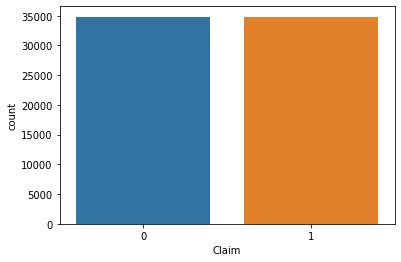

In [37]:
sns.countplot(y_sample)

In [38]:
perf_report = pd.DataFrame()
perf_report = pd.concat([perf_report, pd.DataFrame([{'model':'Random Forest',
                                             'Accuracy': accuracy_score(y_test,y_pred), 
                                            'Precision': precision_score(y_test,y_pred),
                                            'Recall': recall_score(y_test,y_pred),
                                                    'F1':f1_score(y_test,y_pred),
                                                    'Cohens kappa score':cohen_kappa_score(y_test,y_pred)}])],
                                             )


final_pred_smotemodel=rf.predict(df_test_for_pred)

In [39]:
perf_report = pd.concat([perf_report, pd.DataFrame([{'model':'Random Forest - Smote',
                                             'Accuracy': accuracy_score(y_test,y_pred_smote), 
                                            'Precision': precision_score(y_test,y_pred_smote),
                                            'Recall': recall_score(y_test,y_pred_smote),
                                                    'F1':f1_score(y_test,y_pred_smote),
                                                    'Cohens kappa score':cohen_kappa_score(y_test,y_pred_smote)}])],
                                             )

In [40]:
print(perf_report)

                   model  Accuracy  Precision    Recall        F1  \
0          Random Forest  0.944944   0.853674  0.800818  0.826401   
0  Random Forest - Smote  0.944083   0.802145  0.873832  0.836455   

   Cohens kappa score  
0            0.793725  
0            0.802806  


In [47]:
cv_results = cross_validate(rf, X_sample, y_sample, cv=10)

In [49]:
print(cv_results)

{'fit_time': array([101.80788422,  98.5397799 , 101.14384818,  95.33998227,
        99.08834481, 100.02036047,  99.86514735,  99.84176421,
        98.86044502,  95.6058712 ]), 'score_time': array([1.88310957, 1.82279086, 1.78294635, 1.67977905, 1.68717003,
       1.95035005, 1.70046997, 1.91842103, 1.93620729, 1.70517302]), 'test_score': array([0.94790471, 0.94431688, 0.97258898, 0.96713548, 0.96914466,
       0.96684845, 0.97230195, 0.97043628, 0.96971871, 0.96914466])}


In [50]:
cv_results['test_score']

array([0.94790471, 0.94431688, 0.97258898, 0.96713548, 0.96914466,
       0.96684845, 0.97230195, 0.97043628, 0.96971871, 0.96914466])

In [41]:
final_pred_smote=pd.concat(
                    [pd.DataFrame(df_test_ID,columns=['ID']),
                         pd.DataFrame(final_pred_smotemodel,columns=['Claim'])],
                         axis=1)

In [43]:
sv.get_n_quickest_oversamplers(5)

[smote_variants._smote_variants.SPY,
 smote_variants._smote_variants.OUPS,
 smote_variants._smote_variants.SMOTE_D,
 smote_variants._smote_variants.NT_SMOTE,
 smote_variants._smote_variants.Gazzah]

### Writing Prediction to CSV

In [44]:
pd.DataFrame.to_csv(final_pred_smote,'Iteration_3_smote.csv',index=False) 